In [54]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import log_Gamma_2_eta
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_delta_2_eta0
from helper_funcs import logdotexp

# Load in Data

In [71]:
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df_coarse = pd.read_csv("../../dat/Final_Data_Beth.csv")

df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# add dive duration
coarse_features = ['diveDuration']

df = df.merge(df_coarse[['divenum']+coarse_features],
              on = 'divenum',
              how = 'left')

for feature in coarse_features:
    df.loc[df.duplicated(['ID','divenum']),feature] = np.nan

df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
#df['diveDuration'] = np.exp(df['diveDuration'])

df["delt_d"] = df["ad"].diff()
df["elev"] = -df["ad"]

df = df[df["ID"] == "D26"]#.iloc[0:1000]
df = df.reset_index()

#jump_inds = range(len(df))
jump_inds = df.index[~np.isnan(df["diveDuration"])].to_list()

# make the delta_d nan at the start of each dive
df["delt_d"].iloc[jump_inds] = np.nan

# add edives to df
edives = [False]*len(df)
for ind in jump_inds[1:]:
    edives[ind-1] = True
edives[-1] = True
df["e_dive"] = edives

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_27985/1242002585.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_27985/1242002585.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delt_d"].iloc[jump_inds] = np.nan


In [72]:
# populate a data object
data = []

initial_ts = [0]
final_ts = []

features = ['delt_d','e_dive']#'diveDuration','aw1','aw2','aw3','w_low']

means = {feature: df[feature].mean() for feature in features}
stds = {feature: df[feature].std() for feature in features}

for feature in ['delt_d']:#['aw1','aw2','aw3']:
    df[feature] = (df[feature] - means[feature])/stds[feature]

#for feature in ['diveDuration','w_low']:
#    df[feature] = df[feature]/stds[feature]

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({feature : row[1][feature] for feature in features})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

print(initial_ts)
print(final_ts)

[0]
[9566]


In [73]:
'''
### features of data ###
features = {'delt_d'            : {'f'           : 'normal',
                                   'lower_bound' : None,
                                   'upper_bound' : None,
                                   'share_coarse': True,
                                   'share_fine'  : False}}

### load in data ###
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
df["delt_d"] = df["ad"].diff()

whales = pd.unique(df.ID)

# only take whale I107
#whales = ["I145"]
#df = df[df["ID"].isin(whales)]

# convert times
df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# populate a data object
data = []

initial_ts = [0]
final_ts = []

for t,row in enumerate(df.iterrows()):

    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)

    data.append({#"w_low"     : row[1]["w_low"],
                 "delt_d"    : row[1]["delt_d"]})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

T = len(data)
K = [2,3]
'''

'\n### features of data ###\nfeatures = {\'delt_d\'            : {\'f\'           : \'normal\',\n                                   \'lower_bound\' : None,\n                                   \'upper_bound\' : None,\n                                   \'share_coarse\': True,\n                                   \'share_fine\'  : False}}\n\n### load in data ###\ndf = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")\ndf["w_low"] = np.log(df["w_low"])\ndf["w_high"] = np.log(df["w_high"])\ndf["delt_d"] = df["ad"].diff()\n\nwhales = pd.unique(df.ID)\n\n# only take whale I107\n#whales = ["I145"]\n#df = df[df["ID"].isin(whales)]\n\n# convert times\ndf["stime"] = pd.to_datetime(df["stime"])\ndf["etime"] = pd.to_datetime(df["etime"])\n\n# populate a data object\ndata = []\n\ninitial_ts = [0]\nfinal_ts = []\n\nfor t,row in enumerate(df.iterrows()):\n\n    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:\n        final_ts.append(t-1)\n        initial_ts.append(t)\n\n    data.append({#"w_low"

# Load in Whale Data

In [74]:
raw_df = pd.read_csv("../../dat/Final_rawData_Beth.csv", 
                      usecols = ["Time","p","head","pitch","roll","divenum","w_low","w_high","ID"],
                      low_memory = True)

In [75]:
raw_df["Elevation"] = -raw_df["p"]
raw_df["Time"] = pd.to_datetime(raw_df["Time"])
raw_df = raw_df.reset_index(drop=True)

D26


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_27985/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


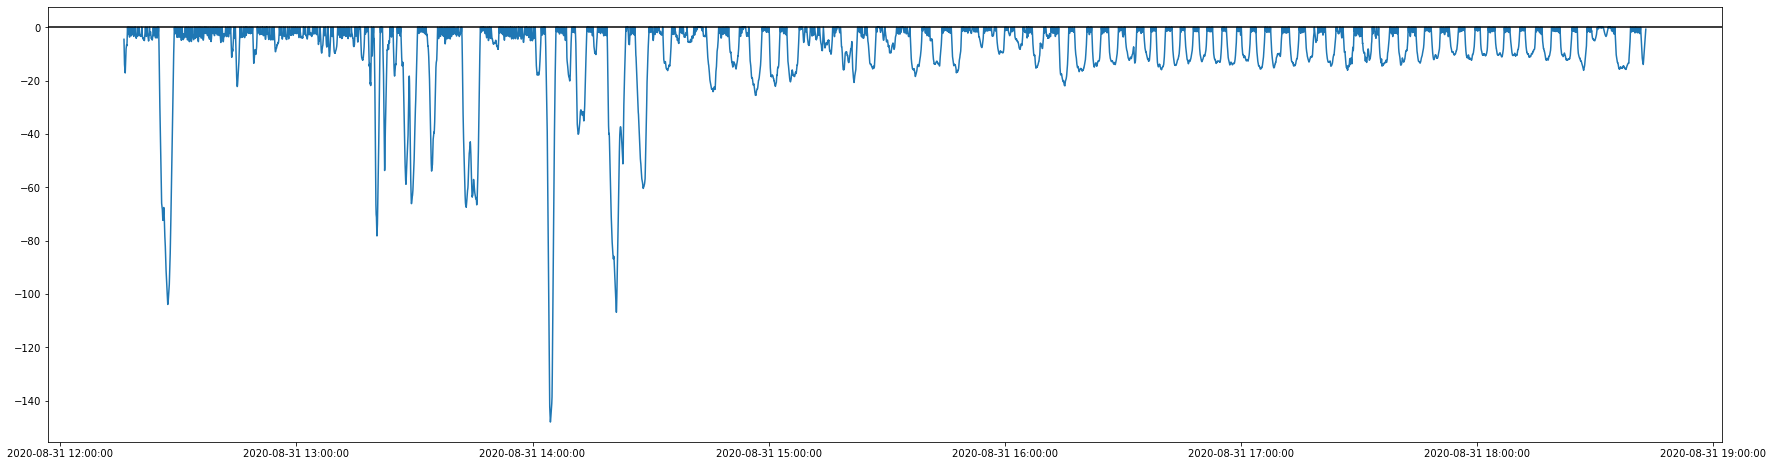

In [76]:
whales = pd.unique(df.ID)
for whale in whales:
    print(whale)
    stime = df.loc[df["ID"].isin([whale]),"stime"].min()
    etime = df.loc[df["ID"].isin([whale]),"etime"].max()
    plt.figure(figsize=(30,8))
    inds = (raw_df["Time"] > stime) & (raw_df["Time"] < etime) & (raw_df["ID"] == whale)
    plt.plot(raw_df[inds].iloc[::50]["Time"],
             raw_df[inds].iloc[::50]["Elevation"])
    plt.locator_params(axis='x', nbins=10)
    plt.axhline(0,color='k')
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.show()

# Load in the HMM

In [77]:
date = "2023-04-09"

param_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/" + date
plot_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/case_study/updown/" + date

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)
    
methods = ["control","BFGS","SAGA","SVRG","GD","CG"]

K = [3,3]

partial_Es = [0.0,0.5,1.0]

tol = 1e-3

optims = {}
times_to_converge = {}
epochs_to_converge = {}
lls = {}

In [78]:
for method in ['BFGS']:#methods:
    for partial_E in [0.0]:#partial_Es:
        if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
            pass
        else:
            
            # get best ll
            best_ll = -np.infty
            #best_fname = param_folder + "/case_study_updown_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            best_fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            
            # initialize lls
            lls[(method,partial_E)] = []
            
            # initialize epochs
            epochs_to_converge[(method,partial_E)] = []
            
            # initialize times
            times_to_converge[(method,partial_E)] = []
            
            for rand_seed in range(1):
                
                fname = param_folder + "/case_study_updown_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                #fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                
                #try:
                with open(fname, 'rb') as f:
                    optim = pickle.load(f)
                print("loaded file %s" % fname)
                #except:
                #    print("file %s does not exist" % fname)
                #    continue
                
                # check for some issue (likely nan in theta)
                if len(optim.time_trace) == 0:
                    print("file %s didn't optimize." % fname)
                    continue
                    
                
                # get convergence ind
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])
                
                if optim.log_like_trace[-1] > best_ll:    
                    optims[(method,partial_E)] = optim
                    best_fname = fname
                    best_ll = optim.log_like_trace[-1]
                    
            print(best_fname)

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-09/case_study_updown_K-3-3_BFGS_0.0_000
/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-09/case_study_updown_K-3-3_BFGS_0.0_000


In [79]:
max_ll = -np.infty
for _,optim in optims.items():
    print(optim.log_like_trace[-1])
    if optim.log_like_trace[-1] > max_ll:
        self = optim
        max_ll = optim.log_like_trace[-1]

-0.8918391629500141


In [80]:
self.theta

[{'delt_d': {'mu': array([ 0.25355348, -0.15054175, -0.53776895]),
   'log_sig': array([-1.65252548, -1.5588619 , -1.35832439])},
  'e_dive': {'logit_p': array([-100, -100,  100])}},
 {'delt_d': {'mu': array([ 1.8286467 , -1.37656892, -2.18185514]),
   'log_sig': array([ 0.57725921,  0.46727628, -0.19424339])},
  'e_dive': {'logit_p': array([-100, -100,  100])}},
 {'delt_d': {'mu': array([ 0.67381044, -0.17988359, -1.26923005]),
   'log_sig': array([-0.90373757, -0.81160561, -1.13497077])},
  'e_dive': {'logit_p': array([-100, -100,  100])}}]

# Repopulate the parameters

In [81]:
self.data = data

self.log_alphas = np.zeros((self.T,self.K_total))
self.log_betas = np.zeros((self.T,self.K_total))

# p_Xt and p_Xtm1_Xt
self.p_Xt = np.zeros((self.T,self.K_total))
self.p_Xtm1_Xt = np.zeros((self.T,self.K_total,self.K_total))

# gradients wrt theta
self.grad_theta_t = [deepcopy(self.theta) for _ in range(self.T)]
self.grad_theta = deepcopy(self.theta)

# gradients wrt eta
self.grad_eta_t = [deepcopy(self.eta) for _ in range(self.T)]
self.grad_eta = deepcopy(self.eta)

# gradients wrt eta0
self.grad_eta0_t = [deepcopy(self.eta0) for _ in range(self.T)]
self.grad_eta0 = deepcopy(self.eta0)

self.E_step()
self.get_log_Gamma(jump=False)
self.get_log_Gamma(jump=True)
self.get_log_delta()

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/helper_funcs.py:109: RuntimeWarning: divide by zero encountered in log
  np.log(C, out=C)


array([  -1.67457002, -101.67457002, -101.67457002,   -0.34173586,
       -100.34173586, -100.34173586,   -2.28204349, -102.28204349,
       -102.28204349])

In [111]:
display(self.theta)
#display(self.theta_SE)

display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][1]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][2]))
#display(self.Gamma_SE)

display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[0]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][0]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][1]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][2]))
#display(self.delta_SE)

[{'delt_d': {'mu': array([ 0.25355348, -0.15054175, -0.53776895]),
   'log_sig': array([-1.65252548, -1.5588619 , -1.35832439])},
  'e_dive': {'logit_p': array([-100, -100,  100])}},
 {'delt_d': {'mu': array([ 1.8286467 , -1.37656892, -2.18185514]),
   'log_sig': array([ 0.57725921,  0.46727628, -0.19424339])},
  'e_dive': {'logit_p': array([-100, -100,  100])}},
 {'delt_d': {'mu': array([ 0.67381044, -0.17988359, -1.26923005]),
   'log_sig': array([-0.90373757, -0.81160561, -1.13497077])},
  'e_dive': {'logit_p': array([-100, -100,  100])}}]

array([[0.70197833, 0.02823629, 0.26978538],
       [0.72613974, 0.08167764, 0.19218262],
       [0.55008247, 0.03223741, 0.41768012]])

array([[7.45573988e-01, 2.43195582e-01, 1.12304302e-02],
       [2.14410119e-44, 5.76359515e-01, 4.23640485e-01],
       [3.72007598e-44, 3.72007598e-44, 1.00000000e+00]])

array([[9.64538741e-01, 3.52759343e-02, 1.85324637e-04],
       [3.61756100e-44, 9.72442773e-01, 2.75572270e-02],
       [3.72007598e-44, 3.72007598e-44, 1.00000000e+00]])

array([[8.90188956e-01, 1.09781764e-01, 2.92805278e-05],
       [3.54892373e-44, 9.53992272e-01, 4.60077277e-02],
       [3.72007598e-44, 3.72007598e-44, 1.00000000e+00]])

array([0.18738873, 0.71053586, 0.1020754 ])

array([1.00000000e+00, 3.72007598e-44, 3.72007598e-44])

array([1.00000000e+00, 3.72007598e-44, 3.72007598e-44])

array([1.00000000e+00, 3.72007598e-44, 3.72007598e-44])

# Plot emission distributions with error bounds

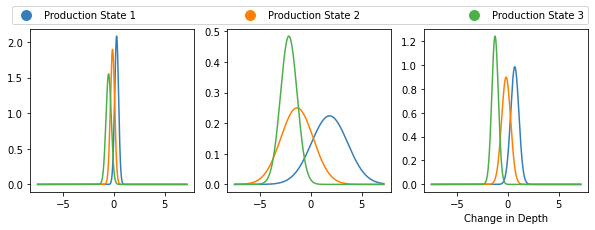

In [84]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# define colors
coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

K_total = self.K[1]*self.K[0]
perc = 0.95

fig,ax = plt.subplots(1,len(self.features)+1,figsize=(10,3))

x_labels = {"diveDuration" : "Dive Duration (s)",
            "maxDepth"     : "Maximum Depth (m)",
            "avg_bot_htv"  : "Average Bottom RHTV (rad/s)",
            "postDiveInt"  : "Post Dive Interval (seconds)",
            "w_low"        : "Wiggliness (low feq)",
            "w_high"       : "Wiggliness (high freq)",
            "delt_d"       : "Change in Depth"}

for fignum,feature in enumerate(['delt_d']):#enumerate(self.features):
    
    # get bounds
    min_mu = np.min([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_mu = np.max([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_sig = np.exp(np.max([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))
    
    x = np.linspace(min_mu-3*max_sig,max_mu+3*max_sig,1000)
    
    # see if we are using a truncnorm
    a = self.features[feature]["lower_bound"]
    b = self.features[feature]["upper_bound"]
    if not a is None:
        a = np.concatenate([self.features[feature]["lower_bound"] for _ in self.theta])
    if not b is None:
        b = np.concatenate([self.features[feature]["upper_bound"] for _ in self.theta])

    # now get the y values for each x
    y0 = np.zeros((1000,K_total))

    # true ys
    mu = np.concatenate([theta_fine[feature]['mu'] for theta_fine in self.theta])
    sig = np.exp(np.concatenate([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))

    for state in range(K_total):
        if (not a is None) and (not b is None):
            y0[:,state] = truncnorm.pdf(x,a=(a[state]-mu[state])/sig[state],
                                          b=(b[state]-mu[state])/sig[state],
                                          loc=mu[state],scale=sig[state])
        else:
            y0[:,state] = norm.pdf(x,mu[state],sig[state])
    
    if feature == "maxDepth":
        ax[fignum].axvline(np.log(20),color='k',linestyle='--')
        ax[fignum].axvline(np.log(5),color='k',linestyle='--')
    
    for fignum,k0 in enumerate(range(self.K[0])):
        for k1 in range(self.K[1]):

            # define state:
            state = fignum*self.K[1] + k1
            
            # plot distribution
            ax[fignum].plot(x,y0[:,state],
                            color=fine_colors[k1])
        
    # add labels
    if fignum == 0:
        ax[fignum].set_ylabel("Probability Density")

    ax[fignum].set_xlabel(x_labels[feature])
    #ax[fignum].set_xscale('log')
        
leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                   markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])]

fig.legend(handles=legend_elements,prop={'size': 10}, ncol=self.K[1], mode="expand", borderaxespad=0.,
             bbox_to_anchor=(0.1, 0.9, 0.8, .1), loc='lower left')

#fig.tight_layout()

fig.savefig(plot_folder+'/emission_dists_K_%d_%d_nWhales_%d.png' % (self.K[0],self.K[1],len(whales)),
            dpi=300,
            bbox_inches='tight')

In [85]:
self.theta

[{'delt_d': {'mu': array([ 0.25355348, -0.15054175, -0.53776895]),
   'log_sig': array([-1.65252548, -1.5588619 , -1.35832439])},
  'e_dive': {'logit_p': array([-100, -100,  100])}},
 {'delt_d': {'mu': array([ 1.8286467 , -1.37656892, -2.18185514]),
   'log_sig': array([ 0.57725921,  0.46727628, -0.19424339])},
  'e_dive': {'logit_p': array([-100, -100,  100])}},
 {'delt_d': {'mu': array([ 0.67381044, -0.17988359, -1.26923005]),
   'log_sig': array([-0.90373757, -0.81160561, -1.13497077])},
  'e_dive': {'logit_p': array([-100, -100,  100])}}]

# Plot Dive Profiles

In [108]:
sseg=-500

D26


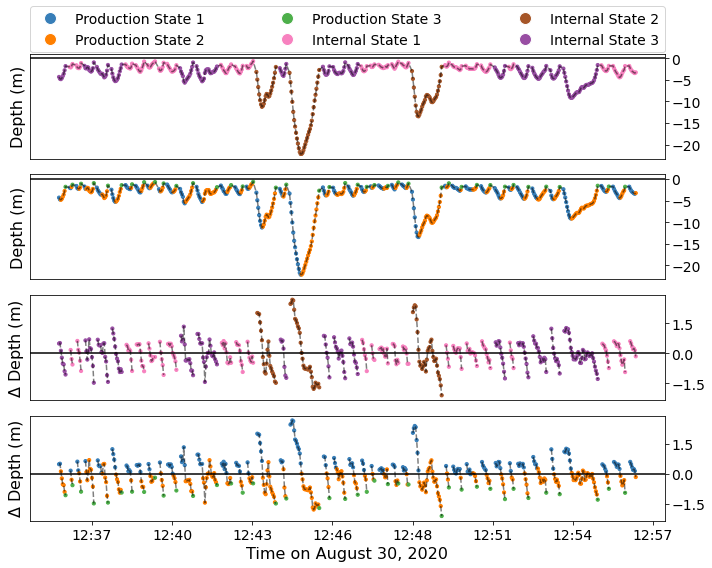

In [110]:
sseg += 500
eseg = sseg + 500
size = 10
figsize = (10,8)

self.p_fine = np.zeros((self.T,self.K[1]))
self.p_coarse = np.zeros((self.T,self.K[0]))

# get p_coarse, p_fine, and CIs
for k0 in range(self.K[0]):
    self.p_coarse[:,k0] = np.sum(self.p_Xt[:,(k0*self.K[1]):((k0+1)*self.K[1])],1)

for k1 in range(self.K[1]):
    self.p_fine[:,k1] = np.sum(self.p_Xt[:,k1::self.K[1]],1)

for whale in ["D26"]:#whales:
    
    print(whale)

    df0 = df[df["ID"] == whale].reset_index().drop("index",axis=1).reset_index()
    df0 = df0[sseg:eseg]

    # get the dive types
    ML_subdivetype = np.argmax(self.p_fine[df["ID"] == whale,:],1)[sseg:eseg]
    ML_divetype = np.argmax(self.p_coarse[df["ID"] == whale,:],1)[sseg:eseg]

    # define colors
    coarse_colors = [CB_color_cycle[i+self.K[1]] for i in ML_divetype]
    fine_colors = [CB_color_cycle[i] for i in ML_subdivetype]

    fig,ax = plt.subplots(4,1,figsize=figsize)

    # get legend
    leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])] + \
                 ['Internal State %d'%(i+1) for i in range(self.K[0])]

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                       markerfacecolor=CB_color_cycle[i], markersize=12) for i in range(self.K[1])] + \
                      [Line2D([0], [0], marker='o', color='w', label=leg_labels[i+self.K[1]],
                       markerfacecolor=CB_color_cycle[i+self.K[1]], markersize=12) for i in range(self.K[0])]


    ax[0].plot(df0['stime'],-df0['ad'],'k--',alpha=0.5)
    ax[0].axhline(0,color='k')
    ax[0].scatter(df0['stime'],-df0['ad'],c=coarse_colors,s=size)
    
    ax[1].plot(df0['stime'],-df0['ad'],'k--',alpha=0.5)
    ax[1].axhline(0,color='k')
    ax[1].scatter(df0['stime'],-df0['ad'],c=fine_colors,s=size)
    
    ax[2].plot(df0['stime'],df0['delt_d'],'k--',alpha=0.5)
    ax[2].axhline(0,color='k')
    ax[2].scatter(df0['stime'],df0['delt_d'],c=coarse_colors,s=size)
    
    ax[3].plot(df0['stime'],df0['delt_d'],'k--',alpha=0.5)
    ax[3].axhline(0,color='k')
    ax[3].scatter(df0['stime'],df0['delt_d'],c=fine_colors,s=size)

    # position legend
    ax[0].legend(handles=legend_elements,prop={'size': 14}, ncol=3, mode="expand", borderaxespad=0.,
                 bbox_to_anchor=(0., 1.01, 1., .102), loc='lower left')

    for ax0 in ax:
        ax0.set_xticks([])

    ax[0].set_ylabel('Depth (m)',fontsize=16)
    ax[2].set_ylabel(r'$\Delta$ Depth (m)',fontsize=16)

    ax[1].set_ylabel('Depth (m)',fontsize=16)
    ax[3].set_ylabel(r'$\Delta$ Depth (m)',fontsize=16)

    ax[-1].set_xlabel("Time on August 30, 2020",fontsize=16)
    ax[-1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

    for ax0 in ax:
        ax0.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax0.yaxis.tick_right()
        for item in ax0.get_yticklabels():
            item.set_fontsize(14)
        for item in ax0.get_xticklabels():
            item.set_fontsize(14)

    plt.tight_layout()
    plt.savefig(plot_folder+'/decoded_dives_kw_%s_K_%d_%d_nWhales_%d.png'%(whale,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()

In [52]:
self.theta

[{'delt_d': {'mu': array([ 0.39479009,  0.01507697, -0.53912794]),
   'log_sig': array([-0.91592305, -1.64369647, -1.10848197])}},
 {'delt_d': {'mu': array([ 1.21971615, -2.96083527, -0.29232032]),
   'log_sig': array([ 0.64030662,  0.40518849, -0.38197374])}}]

In [53]:
self.eta

[array([[ 0.        , -3.3957953 ],
        [ 0.35226174,  0.        ]]),
 [array([[   0.        ,   -1.02139065, -100.        ],
         [-100.        ,    0.        ,   -2.12489898],
         [-100.        , -100.        ,    0.        ]]),
  array([[   0.        ,   -3.56537422, -100.        ],
         [-100.        ,    0.        ,  -14.58538057],
         [-100.        , -100.        ,    0.        ]])]]

In [ ]:
plot_folder+'/decoded_dives_kw_%s_K_%d_%d_nWhales_%d.png'%(whale,self.K[0],self.K[1],len(whales))

In [ ]:
for whale in ["D26"]:#whales:
    
    print(whale)

    df0 = df[df["ID"] == whale].reset_index().drop("index",axis=1).reset_index()
    ind = 280#min(df0[df0.ID == whale]["index"])
    span = 100#len(df0[df0.ID == whale]) - 2
    
    # get delta d
    df0["delt_d"] = df0["ad"].diff()
    raw_df["delt_d"] = raw_df["Elevation"].diff()
    
    print(span)

    # get the dive types
    ML_divetype = np.argmax(self.p_fine,1)
    ML_bouttype = np.argmax(self.p_coarse,1)

    # define colors
    coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
    fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

    fig,ax = plt.subplots(6,1,figsize=(15,15))

    # get legend
    labels = ['Production State 1','Production State 2','Production State 3',
              'Internal State 1','Internal State 2']
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                                      markerfacecolor=fine_colors[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[1],
                                      markerfacecolor=fine_colors[1], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[2],
                                      markerfacecolor=fine_colors[2], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[3],
                                      markerfacecolor=coarse_colors[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[4],
                                      markerfacecolor=coarse_colors[1], markersize=12)]
                       #Patch(facecolor=coarse_colors[0], alpha=0.5, label=labels[4]),
                       #Patch(facecolor=coarse_colors[1], alpha=0.5, label=labels[5])]

    leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])] + \
                 ['Internal State %d'%(i+1) for i in range(self.K[0])]

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                       markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])] + \
                      [Line2D([0], [0], marker='o', color='w', label=leg_labels[i+self.K[1]],
                       markerfacecolor=coarse_colors[i], markersize=12) for i in range(self.K[0])]
    
    fine_df = raw_df[raw_df["Time"] <= df0["etime"].iloc[ind]]
    fine_df = fine_df[fine_df["Time"] >= df0["stime"].iloc[ind]]
    fine_df = fine_df[fine_df["ID"] == whale]
    
    coarse_df = raw_df[raw_df["Time"] <= df0["etime"].iloc[ind]]
    coarse_df = coarse_df[coarse_df["Time"] >= df0["stime"].iloc[ind]]
    coarse_df = coarse_df[coarse_df["ID"] == whale]

    for divenum in range(ind+1,ind+span+1):

        print(divenum)

        dive_df = raw_df[raw_df["Time"] <= df0["etime"].iloc[divenum]]
        dive_df = dive_df[dive_df["Time"] >= df0["stime"].iloc[divenum]]
        dive_df = dive_df[dive_df["ID"] == whale]
        
        # plot dive profiles
        if (ML_divetype[divenum] != ML_divetype[divenum-1]) or \
           (ML_bouttype[divenum] != ML_bouttype[divenum-1]) or \
           (divenum == ind+span):
                    
            ax[0].plot(pd.to_datetime(fine_df["Time"]),
                       fine_df["Elevation"],
                       "k--")

            ax[0].plot(pd.to_datetime(fine_df["Time"]),
                       fine_df["Elevation"],
                       color=fine_colors[ML_divetype[divenum-1]])
            
            ax[1].plot(pd.to_datetime(fine_df["Time"]),
                       np.log(fine_df["w_low"]),
                       color=fine_colors[ML_divetype[divenum-1]])
            
            ax[2].plot(pd.to_datetime(fine_df["Time"]),
                       fine_df["delt_d"],
                       color=fine_colors[ML_divetype[divenum-1]])
            
            fine_df = dive_df
        
        else:
            
            fine_df = pd.concat([fine_df,dive_df])
            
        if (ML_bouttype[divenum] != ML_bouttype[divenum-1]) or \
           (ML_divetype[divenum] != ML_divetype[divenum-1]) or \
           (divenum == ind+span):
            
            ax[3].plot(pd.to_datetime(coarse_df["Time"]),
                       coarse_df["Elevation"],
                       "k--")
            
            ax[3].plot(pd.to_datetime(coarse_df["Time"]),
                       coarse_df["Elevation"],
                       color=coarse_colors[ML_bouttype[divenum-1]])

            ax[4].plot(pd.to_datetime(coarse_df["Time"]),
                       np.log(coarse_df["w_low"]),
                       color=coarse_colors[ML_bouttype[divenum-1]])

            ax[5].plot(pd.to_datetime(coarse_df["Time"]),
                       coarse_df["delt_d"],
                       color=coarse_colors[ML_bouttype[divenum-1]])
            
            coarse_df = dive_df
            
        else:
            
            coarse_df = pd.concat([coarse_df,dive_df])

    # position legend
    ax[0].legend(handles=legend_elements,prop={'size': 14}, ncol=3, mode="expand", borderaxespad=0.,
                 bbox_to_anchor=(0., 1.01, 1., .102), loc='lower left')

    for ax0 in ax:
        ax0.set_xticks([])

    ax[0].set_ylabel('Depth (m)',fontsize=16)
    ax[1].set_ylabel('wiggliness (low)',fontsize=16)
    ax[2].set_ylabel('change in depth',fontsize=16)

    ax[3].set_ylabel('Depth (m)',fontsize=16)
    ax[4].set_ylabel('wiggliness (low)',fontsize=16)
    ax[5].set_ylabel('change in depth',fontsize=16)

    ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[2].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[3].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[4].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[5].yaxis.set_major_locator(plt.MaxNLocator(5))

    ax[-1].set_xlabel("Time on August 30, 2020",fontsize=16)
    ax[-1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

    for ax0 in ax:
        ax0.yaxis.tick_right()
        for item in ax0.get_yticklabels():
            item.set_fontsize(14)
        for item in ax0.get_xticklabels():
            item.set_fontsize(14)

    plt.tight_layout()
    plt.savefig(plot_folder+'/decoded_dives_kw_%s_K_%d_%d_nWhales_%d.png'%(whale,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()